# General Comments/Questions
1. Could come back to Section4, Step 2 to include bounds for different variables in random data to make it more realistic
2. Go through to ensure all variables listed are used
3. Review all comments to make sure it flows
5. Review all Sections & explanations to make sure all content is there


# Troubleshooting notes
1. use "[variable name]." + tab to see all the functions I can use for that variable
2. use "?[variable name]" + run to get some explanation about that variable

# 0. Import libraries [DONE]

In [85]:
import gym
import pandas as pd
import numpy as np
import random
from random import randint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam
import math

# 1. Import household data [DONE-ish...just need to load larger data file once more confident] 
1. Read data from a file I created since the data input to this actual paper was the output of another DRL paper using Markov chain. Used Matlab to randomize household data using online sources. Created 5 types of homes and then distributed 32 households over these profiles as described in report and added noise to ensure dataset was not too clean.


## Input File
InputData_HouseholdStates.xls
spreadsheets:
- time  : timeslot x household
- pmax  : maximum controllable power for a given timeslot x household
- pmin  : minimum controllable power for a given timeslot x household
- pbase : base power for a given timeslot x household


## Variables
Variables to read in data
- d_time       : time stamp for all data
- d_p_base     : base load that cannot be controlled or altered for each household 
- d_p_ctrl_min : conrollable load lower limit for each household
- d_p_ctrl_max : controllable load upper limit for each household

Varaibles used in code
- n            : household #
- input_data   : compile data of system's state with time of day (d_time), electricity price (to be calculated), base load (d_p_base), min. controllable load (d_p_ctrl_min), max controllable load (d_p_ctrl_max), 


## AW Comments on issues to resolve:
0. Need to come back and try actual file once I get this working with the 1 day worth of data before I jump to the 100 days worth of data


In [75]:
#
# Read in raw data
#
d_time = pd.read_excel("InputData_HouseholdStates.xls", sheet_name = "time", header=None)
d_p_base = pd.read_excel("InputData_HouseholdStates.xls", sheet_name = "pbase", header=None)
d_p_ctrl_min = pd.read_excel("InputData_HouseholdStates.xls", sheet_name = "pmin", header=None)
d_p_ctrl_max = pd.read_excel("InputData_HouseholdStates.xls", sheet_name = "pmax", header=None)
n = len(d_time.columns)



# 2. Compile household data with electricity price [DONE]
1. Create definition for electricity price with respect to time based on Figure 4 in paper. Assume electricity price is time of use piecewise structure and applies 7-days a week, regardless if its a holiday or not.
2. Compile all data read in with electricity data to produce one tuple with all data across all households.


## Variables
- f_electricity_price : calculates price of electricity give hour of day
- tod                 : time of day (hour from 1 to 24)
- i, j                : iterators for household and timestep respectively

Format of input_data variable:
input_data[household number][type of data][timeslot]


## AW Comments on issues to resolve:



In [87]:
#
# Compile household data in usable format
#

# Initalize matrix
input_data = np.empty((d_time.shape[0],5,n),dtype=object) # 5 is for the 3 power variables, time & electricity rate

# TEST POINT
# print("Section 1: number of households", n, ", initalized input_data matrix to size: ,", input_data.shape)

# function to calculate electricity price given time
def f_electricity_price(t):

    tod = t-(24*(math.ceil(t/24)-1))

    if tod < 1 or tod > 24:
            roh = "error"

    elif tod >= 19 and tod < 22:       
            roh = 4.5

    elif tod >= 16 and tod < 19:
            roh = 4

    elif (tod >= 7 and tod < 13 ) or (tod >= 22) or (tod < 4):
            roh = 2.5

    else:
            roh =1
                
    return roh

# Fill in inpiut_data matrix
for i in range(0,n): # iterate ober household data
    for j in range (0,(len(d_time.index))): # iterate over timestep
        input_data[j][0][i] = d_time[i][j]# time stamp for house i
        input_data[j][1][i] = f_electricity_price(d_time[i][j])# electricity price for house i
        input_data[j][2][i] = d_p_base[i][j] # baseload power for house i
        input_data[j][3][i] = d_p_ctrl_min[i][j] # minimum controllable load for house i
        input_data[j][4][i] = d_p_ctrl_max[i][j] # maximum controllable load for house i
       
        
# TEST POINT
#print("Section 2: input_data table", input_data)

In [88]:
print(input_data[:,1:5,0])

[[2.5 1.0285908113361752 4.302203431234575 5.087749991311358]
 [2.5 0.7828684498659001 4.294428351701952 4.9799567479923725]
 [2.5 0.4758187369718752 4.558883101299438 4.9462595284009]
 ...
 [2.5 2.8838587664272595 5.421236984334797 5.737564779806022]
 [2.5 1.942391370147879 4.847379998047789 5.141763350205425]
 [2.5 1.2167029422419942 4.430178196256576 4.956063883678487]]


# 3. Intialize variables [DONE]
1. Initalize time & error, epsilon. Then randomly initialize DNN variables theta_pol & theta_vf.


## Variables
- t         : time
- epsilon   : error value where it's acceptable that the gradient descent error is negligible indicating we are at                   optimium
- theta_pol : DNN actor parameter
- theta_vf  : DNN critic parameter

## TROUBLESHOOT IDEAS: 
- change randint() range for thetas!
- Make sure this isn't too random...might be better to init these closer to when they are used. Leaving it this way for now because of the structure for AC-Test 3 code I'm referencing.

## AW COMMENTS:
1. 


In [89]:
#
# Initalize values
#
t = 1
epsilon = 10**-3

#
# Federated learning variables
#
num_groups = int(4)
n_per_group = int(n/num_groups)
group_index = np.linspace(0, 24, 4)
household_data_groups = np.empty((4,5,8),dtype=object)

#
# DNN variables
#
theta_pol = np.empty((n,(d_time.shape[0])),dtype='float64')  
theta_vf = np.empty((n,(d_time.shape[0])),dtype='float64')

eta_vf = np.empty((n,(d_time.shape[0])),dtype='float64') 
mu_pol = np.empty((n,(d_time.shape[0])),dtype='float64')

state_result = np.empty((n,(d_time.shape[0])),dtype='float64') # state result of running DNN for each house @ time=t
cost = np.empty((n,(d_time.shape[0])),dtype='float64') 

# fill in values for steps to be used in DNN training
for i in range(0,n): # iterate ober household data
    for j in range (0,(len(d_time.index))): # iterate over timestep
        eta_vf[i,j] = 15/pow(j+1,0.7)
        mu_pol[i,j] = 8/(j+1)
        if j==0 : # randomly initalize DNN variables for each household
            theta_pol[i,j] = randint(0,10)
            theta_vf[i,j] = randint(0,10)
            
# initalize DNN variables from Section 5
action_probs_history = []
state_output_history = [] # this variable was created to track the state that was output from the environment if the action was taken
critic_value_history = []
episode_count = 0

# setup DNN varaibles for actor and critic from Section 5
num_inputs = 4
num_actions = 3 # this may need to be 3 for the policy the way it's shown in Fig 3 ***
num_hidden1 = 6 
num_hidden2 = 18
num_hidden3 = 6# double check if this is right ***
discount_factor = 0.99  # Discount factor for past rewards/costs


# TEST POINT
#print("Section 3: time", t, ",epsilon,", epsilon, ",theta policy, ", theta_pol, ", theta value function,", theta_vf)


# 4. Decentralized learning & information exchange
1. For federated learning, divide up households by an arbitrary number (4 in this case) to use decentralized learning and to anonymize household data. Divide up homes into number of groups, recognizing if uneven number 1 group will have more data. 
2. Create random data that will be used to mask household data when returned to aggregator. This random data is in the exact same format as p_base, p_ctrl_min, p_ctrl_max. 
3. Households aggergate household data with random data sent from aggregator.
4. Aggregator removes random data they added from each group to be left with the real data anonymized.
5. Aggregates lamda & gamma for all household's states for base, min & max. This variable is visible to all households for DNN training.


## Variables
- num_groups            : choose the number of groupings there should be for all households
- n_per_group           : number of houses to be included in each group
- group_index           : index for starting home in each group
- household_data_groups : all household data saved in groups
- lamda_bar             : aggregate values of household data for value function
- gamma_bar             : aggregate values of household data for policy
- i                     : iterators for number of groups
- random_data           : random data generated only aggregator knows for each group
- system_data           : system data passed using federated learning
- base                  : summed base power load at time t for all households
- min_ctrl              : summed minimum controllable power load at time t for all households
- max_ctrl              : summed maximum controllable power load at time t for all households

## AW Comments on issues to resolve:
1. Add iteration over houses at right before Step 6
2. Step 6: Figure out value function equation (10) implementation, including if transitional probability matrix is needed
3. Step 6: Update both theta...although this may be Adam SGD... also if we need to use a for loop to fill in the same equation for all houses @ time = t
4. Step 6: need to write def value_f script, potentially using transitions matrix I began writing

# ITERATING CODE NEEDS TO BE CLUMPED TOGETHER BELOW:

while (insert 2 error arguments here)
t += 1
...continue with code below

while theta_pol


In [90]:
#
# Step 1: create different group data
#
for i in range(0,num_groups):
    print(i)
    t_time = input_data[t,0,int(group_index[i]):int(group_index[i]+n_per_group)]
    t_elec_price = input_data[t,1,int(group_index[i]):int(group_index[i]+n_per_group)]
    t_base = input_data[t,2,int(group_index[i]):int(group_index[i]+n_per_group)]
    t_min = input_data[t,3,int(group_index[i]):int(group_index[i]+n_per_group)]
    t_max = input_data[t,4,int(group_index[i]):int(group_index[i]+n_per_group)]
    household_data_groups[i] = [t_time, t_elec_price, t_base, t_min, t_max]
    
# TEST POINT
#print("Section 4, Step 1: read in all group data.")
#print("Group 1=", household_data_groups[0])
#print("Group 2=", household_data_groups[1])
#print("Group 3=", household_data_groups[2])
#print("Group 4=", household_data_groups[3])


#
#Step 2: Generate random data for each group
#
random_data = household_data_groups.shape
random_data = np.random.rand(*random_data)

# TEST POINT
#print("Section 4, Step 2: Random data generated", random_data)


#
# Step 3: Merge 2 tuples to send from households to aggregator
#
system_data = household_data_groups
system_data = np.append(system_data, random_data, axis = 0)
# TEST POINT
# print("Section 4, Step 3: ensure random data & household group data merged properly", system_data)


#
# Step 4: remove random_data from system_data
#
system_data_clean = system_data
delete_index = []
it = 0
for i in range(system_data.shape[0]):
    for j in range(random_data.shape[0]):
        if (random_data [j,:,:] == system_data[i,:,:]).any():
            # print("deleting at i =", i, "& j = ", j)
            delete_index.insert(it,i)
            it +=1
                   
system_data_clean = np.delete(system_data,delete_index,0)            
# TEST POINT
#print("Section 4, Step 4: ensure system data was removed of random data",system_data_clean)


#
# Step 5: Aggregate all system level data
#
lamda_bar = np.empty(3)
gamma_bar = np.empty(3)

base = np.sum(system_data[:,2,:])
min_ctrl = np.sum(system_data[:,3,:])
max_ctrl = np.sum(system_data[:,4,:])

lamda_bar = [base,min_ctrl,max_ctrl]
gamma_bar = lamda_bar

# TEST POINT
#print("Section 4, Step 5: Aggregated base, min & max values saved in lambda bar =", lamda_bar)
#print("and gamma bar", gamma_bar)

0
1
2
3


# 5. Actor Critic Updates
0. run DNNs
1. Each household calculates its TD error from previous time slot
2. Calculate updated values for: theta_vf (11), theta_pol (12), theta_vf_hat (13a), theta_pol_hat (13b)
3. Send theta_vf_hat, theta_pol_hat to aggregator
4. Aggregator computes theta_vf_hat(0), theta_pol_hat(0) for system & sends to each household
5. House hold updates theta_vf_hat, theta_pol_hat to match system value, i.e. theta_vf_hat(0), theta_pol_hat(0)

## Variables
- theta_vf      : value function parameters for DNN for each household
- theta_pol     : policy parameters for DNN for each household
- theta_vf_hat  : value function average value of parameters calculated for system 
- theta_pol_hat : policy average value of parameters calculated for system 

## AW Comments on issues to resolve:   

1. Need help figuring out Adam optimizer...is this the calculation for theta_vf & theta_pol? Look to code example 2 (not working but could read through website)

2. 

3. Fix different learning rates for actor and critic: 15/t^0.7 for critic and 8/t for actor

4. Come back and add bias term in to NN (couldn't get the comment notation to work in other example of AC working). Could alternatively have another layer for the bias term and the the regular DNN after???

5. Need to figure out how to calculate state & action within my context...

6. Not using theta in DNN training...


## Troubleshoot ideas
1. Remove max_steps_per_episode in case that's limiting training

In [79]:
class ActorCriticNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=6, fc2_dims=18,fc3_dims=6,
            name='actor_critic', chkpt_dir='tmp/actor_critic'):
        super(ActorCriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.fc3_dims = fc3_dims
        self.n_actions = n_actions
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_DR')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.fc3 = Dense(self.fc3_dims, activation='relu')
        self.v = Dense(1, activation=None)
        self.pi = Dense(n_actions, activation='softmax')

    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(value)
        value = self.fc3(value)

        v = self.v(value)
        pi = self.pi(value)

        return v, pi

In [147]:
class Agent:
    def __init__(self, alpha=0.0003, gamma=0.99, n_actions=3):
        self.gamma = gamma
        self.n_actions = n_actions
        self.action = None
        self.delta = 0
        self.action_space = [i for i in range(self.n_actions)]

        self.actor_critic = ActorCriticNetwork(n_actions=n_actions)

        self.actor_critic.compile(optimizer=Adam(learning_rate=alpha))


    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])
        _, probs = self.actor_critic(state)

        action_probabilities = tfp.distributions.Categorical(probs=probs)
        action = action_probabilities.sample()
        log_prob = action_probabilities.log_prob(action)
        self.action = action

        return action.numpy()[0]

    def save_models(self):
        print('... saving models ...')
        self.actor_critic.save_weights(self.actor_critic.checkpoint_file)

    def load_models(self):
        print('... loading models ...')
        self.actor_critic.load_weights(self.actor_critic.checkpoint_file)
        
    def learn(self, state, reward, state_, done):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        state_ = tf.convert_to_tensor([state_], dtype=tf.float32)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32) # not fed to NN
        with tf.GradientTape(persistent=True) as tape:
            state_value, probs = self.actor_critic(state)
            state_value_, _ = self.actor_critic(state_)
            state_value = tf.squeeze(state_value)
            state_value_ = tf.squeeze(state_value_)

            action_probs = tfp.distributions.Categorical(probs=probs)
            log_prob = action_probs.log_prob(self.action)

            delta = reward + self.gamma*state_value_*(1-int(done)) - state_value
            actor_loss = -log_prob*delta
            critic_loss = delta**2
            total_loss = actor_loss + critic_loss
            self.delta = delta

        gradient = tape.gradient(total_loss, self.actor_critic.trainable_variables)
        self.actor_critic.optimizer.apply_gradients(zip(
            gradient, self.actor_critic.trainable_variables))

In [167]:
import matplotlib.pyplot as plt

reward_history = []
value_history = []
prob_history = []
delta_history = []
P_ctrl_history = []
P_ctrl_cost_history = []
load_checkpoint = False
#timevec = range(d_time[:,0])
#print(system_data_clean)
agent = Agent(alpha=0.003, n_actions=100)
for i in range (0,(len(d_time.index)-1)): 
    observation = [input_data[i,1:5,0]]
    #print(i)
    action = agent.choose_action(observation)
    P_ctrl = input_data[i,2,0] + action * (input_data[i,4,0] - input_data[i,3,0])
    observation_ = [input_data[i+1,1:5,0]]
    # calculate discomfort rate as mentioned in paper equation (5)
    if (t < 6 or t > 21):
        discomfort = random.uniform(0.1,1)
    else:
        discomfort = 5
    reward = -(input_data[i,1,0]* P_ctrl + discomfort*abs(input_data[i,4,0]-P_ctrl))
    reward_history.append(reward)
    val, prob = agent.actor_critic.call(tf.convert_to_tensor([observation], dtype=tf.float32))
    P_ctrl_cost = input_data[i,1,0]* P_ctrl
    delta_history.append((agent.delta))
    value_history.append(val)
    prob_history.append(prob)
    P_ctrl_history.append(P_ctrl)
    P_ctrl_cost_history.append(P_ctrl_cost)
    done = False
    agent.learn(observation, reward, observation_, done)
    agent.save_models()
                

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving models ...
... saving

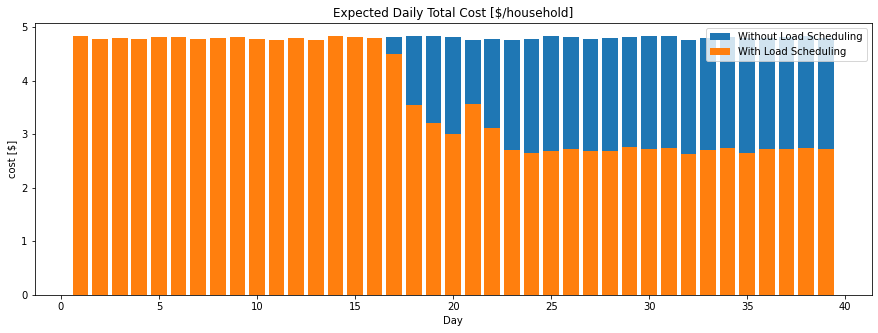

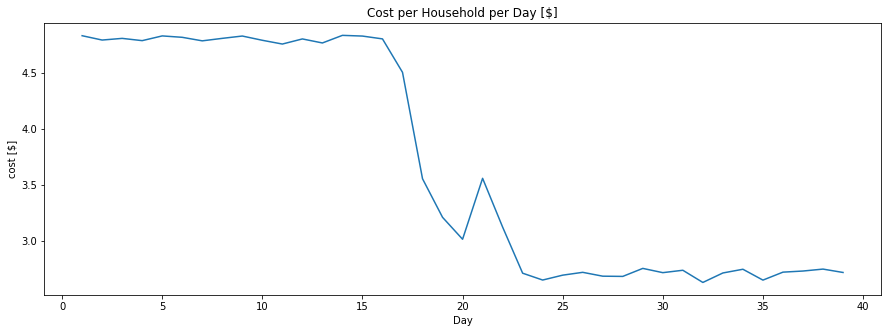

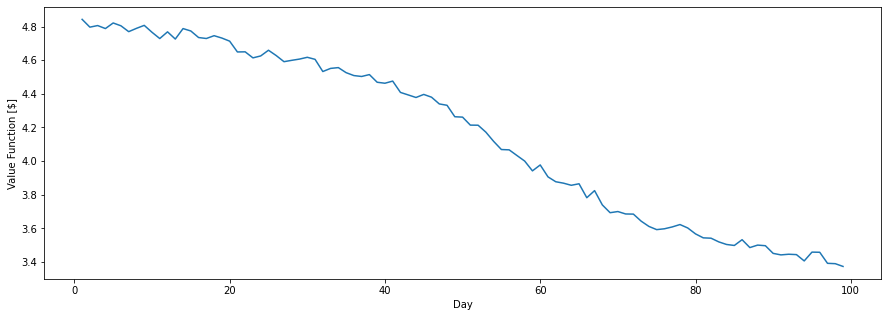

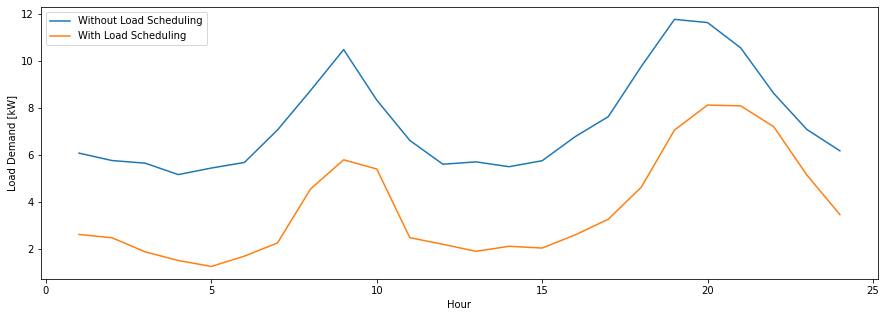

52.764357961678336
[77.1373611551554]
[16.487416758882112]


In [307]:
#input data 0 --> time | 1 --> cost |2 --> base |3 --> min |4 --> max
val_history = np.array(value_history)
val_history=((val_history.reshape(2399,1)))


tot_days = math.floor(input_data[-1,0,0]/24)
p_cntrl_day_hist = P_ctrl_history[2375:2399]
p_base_day_hist = input_data[2376:2400,2,0]
p_max_day_hist =input_data[2376:2400,4,0]

p_cntrl_day_hist = np.array(p_cntrl_day_hist).reshape(24,1)
p_base_day_hist = np.array(p_base_day_hist).reshape(24,1)
p_max_day_hist = np.array(p_max_day_hist).reshape(24,1)

p_base_days = []
p_max_days = []
p_ctrl_days = []
p_tot_days = []
p_tot_cost_days = []
p_max_cost_days = []
val_function_days = []
days = []
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
for i in range(1, tot_days):
    days.append(i)
    data_start = (((i-1)*24))
    data_end = i*24-1

    p_base_day = sum(input_data[data_start:data_end,2,0])
    p_base_days.append(p_base_day) 
    p_max_day = sum(input_data[data_start:data_end,4,0])
    p_max_days.append(p_max_day) 
    p_ctrl_day = sum(P_ctrl_history[data_start:data_end])
    p_ctrl_day_filt = min((p_ctrl_day+p_base_day), (p_max_day+p_base_day))
    p_ctrl_days.append(p_ctrl_day_filt) 
    p_tot_days.append(p_max_day+p_base_day)
    
    p_max_cost_day = sum(np.multiply((input_data[data_start:data_end,2,0] + input_data[data_start:data_end,4,0]), input_data[data_start:data_end,1,0]))
    p_tot_cost_day = sum(P_ctrl_cost_history[data_start:data_end]) + sum(np.multiply((input_data[data_start:data_end,2,0]), input_data[data_start:data_end,1,0]))
    p_tot_cost_filt = min(p_tot_cost_day, p_max_cost_day)/100
    p_tot_cost_days.append(p_tot_cost_filt)
    p_max_cost_days.append(p_max_cost_day/100)
    
    val_function_day = p_max_cost_day/100 + (p_max_cost_day/100)*np.average(val_history[data_start:data_end])/100
    val_function_days.append(val_function_day)

    


plt.figure(figsize=(15, 5))
plt.bar(days[0:39], p_max_cost_days[0:39], label="Without Load Scheduling")
plt.bar(days[0:39], p_tot_cost_days[0:39], label="With Load Scheduling")
plt.title("Expected Daily Total Cost [$/household]")
plt.xlabel("Day")
plt.ylabel("cost [$]")
plt.legend()
plt.show() 

plt.figure(figsize=(15, 5))
plt.plot(days[0:39], p_tot_cost_days[0:39])
plt.title("Cost per Household per Day [$]")
plt.xlabel("Day")
plt.ylabel("cost [$]")
plt.show() 

plt.figure(figsize=(15, 5))
plt.plot(days, val_function_days)
plt.xlabel("Day")
plt.ylabel("Value Function [$]")
plt.show() 


plt.figure(figsize=(15, 5))
x =np.arange(1,25,1)
y1 = (np.add(p_max_day_hist, p_base_day_hist))
y2 = (np.add(p_cntrl_day_hist, p_base_day_hist))

p1 = plt.plot(x, y1, label="Without Load Scheduling")
plt.plot(x, y2, label="With Load Scheduling")
plt.xlabel("Hour")
plt.ylabel("Load Demand [kW]")
plt.legend()
plt.show() 

demand_diff = np.multiply(np.divide(np.subtract(y1,y2), y1),100)
demand_diff_ave = (np.average(demand_diff))
max_demand_diff = max(demand_diff)
min_demand_diff = min(demand_diff)

print(demand_diff_ave)
print(max_demand_diff)
print(min_demand_diff)


(2399, 1)


/Users/jayantsachdev/opt/anaconda3/envs/[MLAI]/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


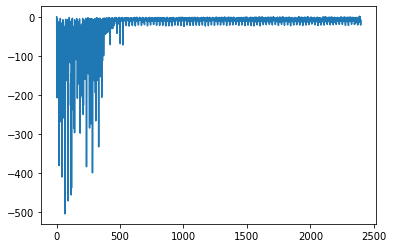

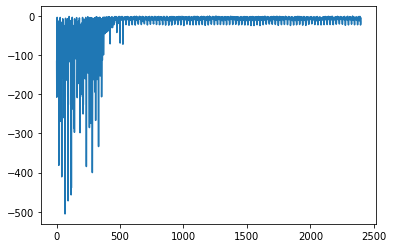

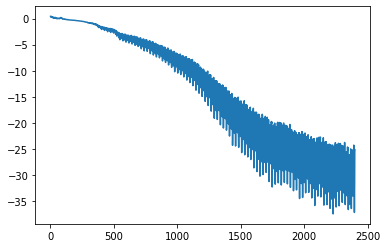

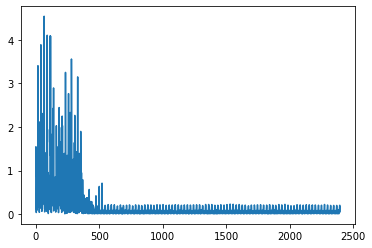

In [173]:

#print(input_data[0:23,0,0].shape)
#print((value_history))

print((val_history.shape))
plt.figure()
plt.plot(input_data[0:2399,0,0], delta_history)
plt.show()

plt.figure()
plt.plot(input_data[0:2399,0,0], reward_history)
plt.show()

plt.figure()
plt.plot(input_data[0:2399,0,0], val_history)
plt.show()

plt.figure()
plt.plot(input_data[0:2399,0,0], [x / 100 for x in P_ctrl_cost_history])
plt.show()

# 7. Figures & Tables
1. Reproduce Figure 5 in paper
2. Reproduce Figure 6a in paper
3. Reproduce Figure 6b in paper
4. Reproduce Figure 6c in paper
5. Reproduce Figure 6d in paper
6. From my notes, create (1) as a graph
7. From my notes, create (2) in a table
8. From my notes, create (3) as a graph (not bars as in Figure 6d)
9. From my notes, create (4) in a table
10. From my notes, create (5) ??? not sure about this***
